In [105]:
import numpy as np
import pandas as pd
import statsmodels
from datetime import date
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [200]:
ether_data = pd.read_csv("Datasets/ETHUSD_Bitfinex_D_historical.csv")
ether_data.drop(labels=["Pair", "Volume_USD"], axis=1, inplace=True)
ether_data.rename(columns={"Volume_CCY":"Volume"}, inplace=True)
ether_data["Date"] = ether_data["TimeStamp"].apply(lambda timestamp: date.fromtimestamp(timestamp)).astype("datetime64")
ether_data = ether_data.set_index("Date")
ether_data.drop(labels="TimeStamp", axis=1, inplace=True)
ether_data["Year"] = ether_data.index.year
ether_data["Month"] = ether_data.index.month_name()
ether_data["Weekday"] = ether_data.index.day_name()
column_sequence = ["Year", "Month", "Weekday", "Open", "High", "Low", "Close", "Volume"]
ether_data = ether_data.reindex(columns=column_sequence)
ether_data = ether_data.sort_values("Date")

In [107]:
ether_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1809 entries, 2016-03-09 to 2021-02-19
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     1809 non-null   int64  
 1   Month    1809 non-null   object 
 2   Weekday  1809 non-null   object 
 3   Open     1809 non-null   float64
 4   High     1809 non-null   float64
 5   Low      1809 non-null   float64
 6   Close    1809 non-null   float64
 7   Volume   1809 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 127.2+ KB


In [108]:
ether_data.isnull().sum()

Year       0
Month      0
Weekday    0
Open       0
High       0
Low        0
Close      0
Volume     0
dtype: int64

In [194]:
ether_data

,Year,Month,Weekday,Open,High,Low,Close,Volume
Date,,,,,,,,
2016-03-09,2016,March,Wednesday,10.300000,11.200000,10.10,11.200000,41.170000
2016-03-10,2016,March,Thursday,11.200000,11.850000,11.07,11.750000,1.030000
2016-03-11,2016,March,Friday,11.750000,11.950000,11.75,11.950000,50.850000
2016-03-12,2016,March,Saturday,11.950000,13.450000,11.95,12.920000,237.780000
2016-03-13,2016,March,Sunday,12.920000,15.070000,12.92,15.070000,369.640000
...,...,...,...,...,...,...,...,...
2021-02-15,2021,February,Monday,1801.300000,1837.125887,1649.00,1779.425051,166031.099289
2021-02-16,2021,February,Tuesday,1778.500000,1828.300000,1725.00,1784.600000,106270.793237
2021-02-17,2021,February,Wednesday,1783.710981,1856.900000,1735.30,1848.700000,81646.318659


In [110]:
ether_data.describe()

,Year,Open,High,Low,Close,Volume
count,1809.000000,1809.000000,1809.000000,1809.000000,1809.000000,1.809000e+03
mean,2018.158098,280.178019,291.973917,267.115741,281.243441,1.567702e+05
std,1.447989,296.450262,311.292744,280.463620,298.940045,1.693212e+05
min,2016.000000,6.682000,7.324000,5.861000,6.702000,0.000000e+00
25%,2017.000000,105.810000,109.170000,101.400000,106.050000,4.859756e+04
50%,2018.000000,206.560000,213.840000,197.860000,206.570000,1.096355e+05
75%,2019.000000,355.500000,371.000000,345.610000,355.620000,1.958973e+05
max,2021.000000,1938.300000,1948.845968,1934.800000,1941.600000,1.620940e+06


In [167]:
min_max_scaler = MinMaxScaler(feature_range=(0,10))
values_to_be_scaled = ether_data.values
scaled_values = min_max_scaler.fit_transform(values_to_be_scaled[:, 3:])
normalized_ether_data = pd.DataFrame(scaled_values, columns=column_sequence[3:])
normalized_ether_data["Date"] = ether_data.index
normalized_ether_data = normalized_ether_data.set_index("Date")

In [193]:
normalized_ether_data

,Open,High,Low,Close,Volume
Date,,,,,
2016-03-09,0.018730,0.019964,0.021976,0.023247,0.000254
2016-03-10,0.023390,0.023312,0.027004,0.026089,0.000006
2016-03-11,0.026237,0.023827,0.030530,0.027123,0.000314
2016-03-12,0.027272,0.031553,0.031567,0.032136,0.001467
2016-03-13,0.032294,0.039897,0.036595,0.043248,0.002280
...,...,...,...,...,...
2021-02-15,9.290750,9.424575,8.518356,9.161842,1.024289
2021-02-16,9.172714,9.379116,8.912355,9.188588,0.655612
2021-02-17,9.199692,9.526423,8.965753,9.519871,0.503697


In [169]:
normalized_ether_data.describe()

,Open,High,Low,Close,Volume
count,1809.000000,1809.000000,1809.000000,1809.000000,1809.000000
mean,1.415891,1.466117,1.354396,1.418894,0.967156
std,1.534725,1.603344,1.453979,1.544991,1.044587
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.513186,0.524568,0.495293,0.513453,0.299811
50%,1.034770,1.063681,0.995361,1.032964,0.676370
75%,1.805833,1.873149,1.761326,1.803289,1.208542
max,10.000000,10.000000,10.000000,10.000000,10.000000


In [170]:
normalized_ether_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1809 entries, 2016-03-09 to 2021-02-19
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1809 non-null   float64
 1   High    1809 non-null   float64
 2   Low     1809 non-null   float64
 3   Close   1809 non-null   float64
 4   Volume  1809 non-null   float64
dtypes: float64(5)
memory usage: 84.8 KB


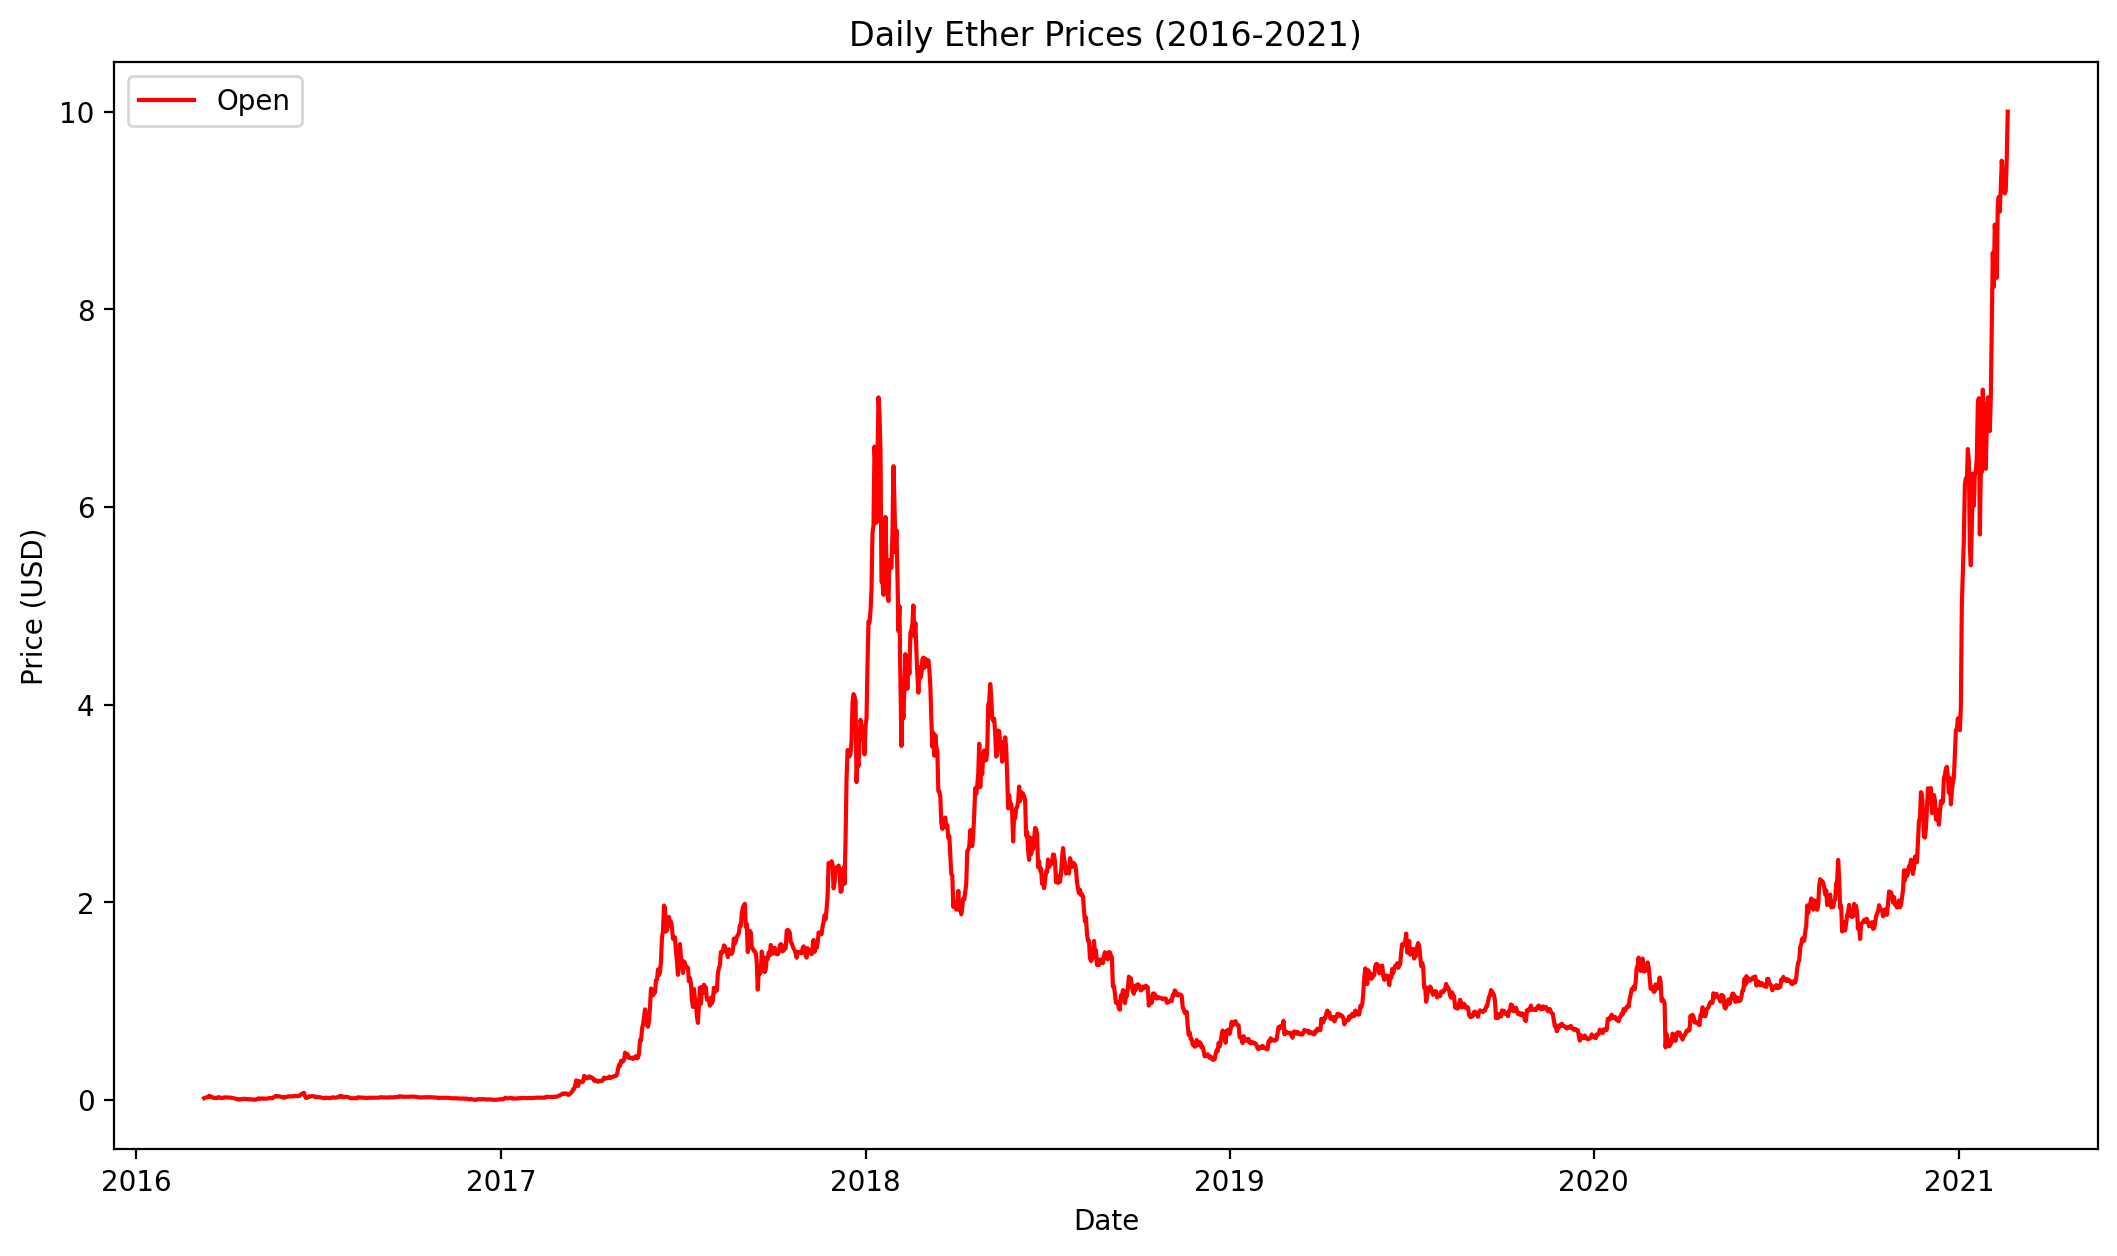

In [206]:
plt.figure(figsize=(12.80, 7.20), dpi=200)
plt.plot(normalized_ether_data["Open"], color="red", label="Open")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Daily Ether Prices (2016-2021)")
plt.show()

In [212]:
rolling_mean = normalized_ether_data.rolling(window=30).mean()
rolling_standard_deviation = normalized_ether_data.rolling(window=30).std()
rolling_mean.dropna(axis=0, inplace=True)
rolling_standard_deviation.dropna(axis=0, inplace=True)

In [213]:
rolling_mean

,Open,High,Low,Close,Volume
Date,,,,,
2016-04-07,0.025283,0.024493,0.025807,0.025038,0.072510
2016-04-08,0.025240,0.024345,0.025720,0.024782,0.074028
2016-04-09,0.024979,0.024062,0.025362,0.024334,0.077844
2016-04-10,0.024531,0.023629,0.024632,0.023784,0.087939
2016-04-11,0.023946,0.022854,0.023951,0.023053,0.091432
...,...,...,...,...,...
2021-02-15,7.635747,7.987153,7.274988,7.716911,1.415082
2021-02-16,7.730572,8.082475,7.372036,7.811558,1.405850
2021-02-17,7.825245,8.184405,7.467218,7.912804,1.398953


In [214]:
rolling_standard_deviation

,Open,High,Low,Close,Volume
Date,,,,,
2016-04-07,0.005249,0.005744,0.005099,0.005440,0.061095
2016-04-08,0.005309,0.005918,0.005188,0.005703,0.059790
2016-04-09,0.005587,0.006168,0.005459,0.006110,0.058543
2016-04-10,0.006007,0.006623,0.006166,0.006575,0.069750
2016-04-11,0.006560,0.007014,0.006492,0.006827,0.067869
...,...,...,...,...,...
2021-02-15,1.164885,1.124362,1.174331,1.168109,0.797473
2021-02-16,1.170528,1.116836,1.185657,1.168498,0.804820
2021-02-17,1.170670,1.103924,1.195449,1.180892,0.811840


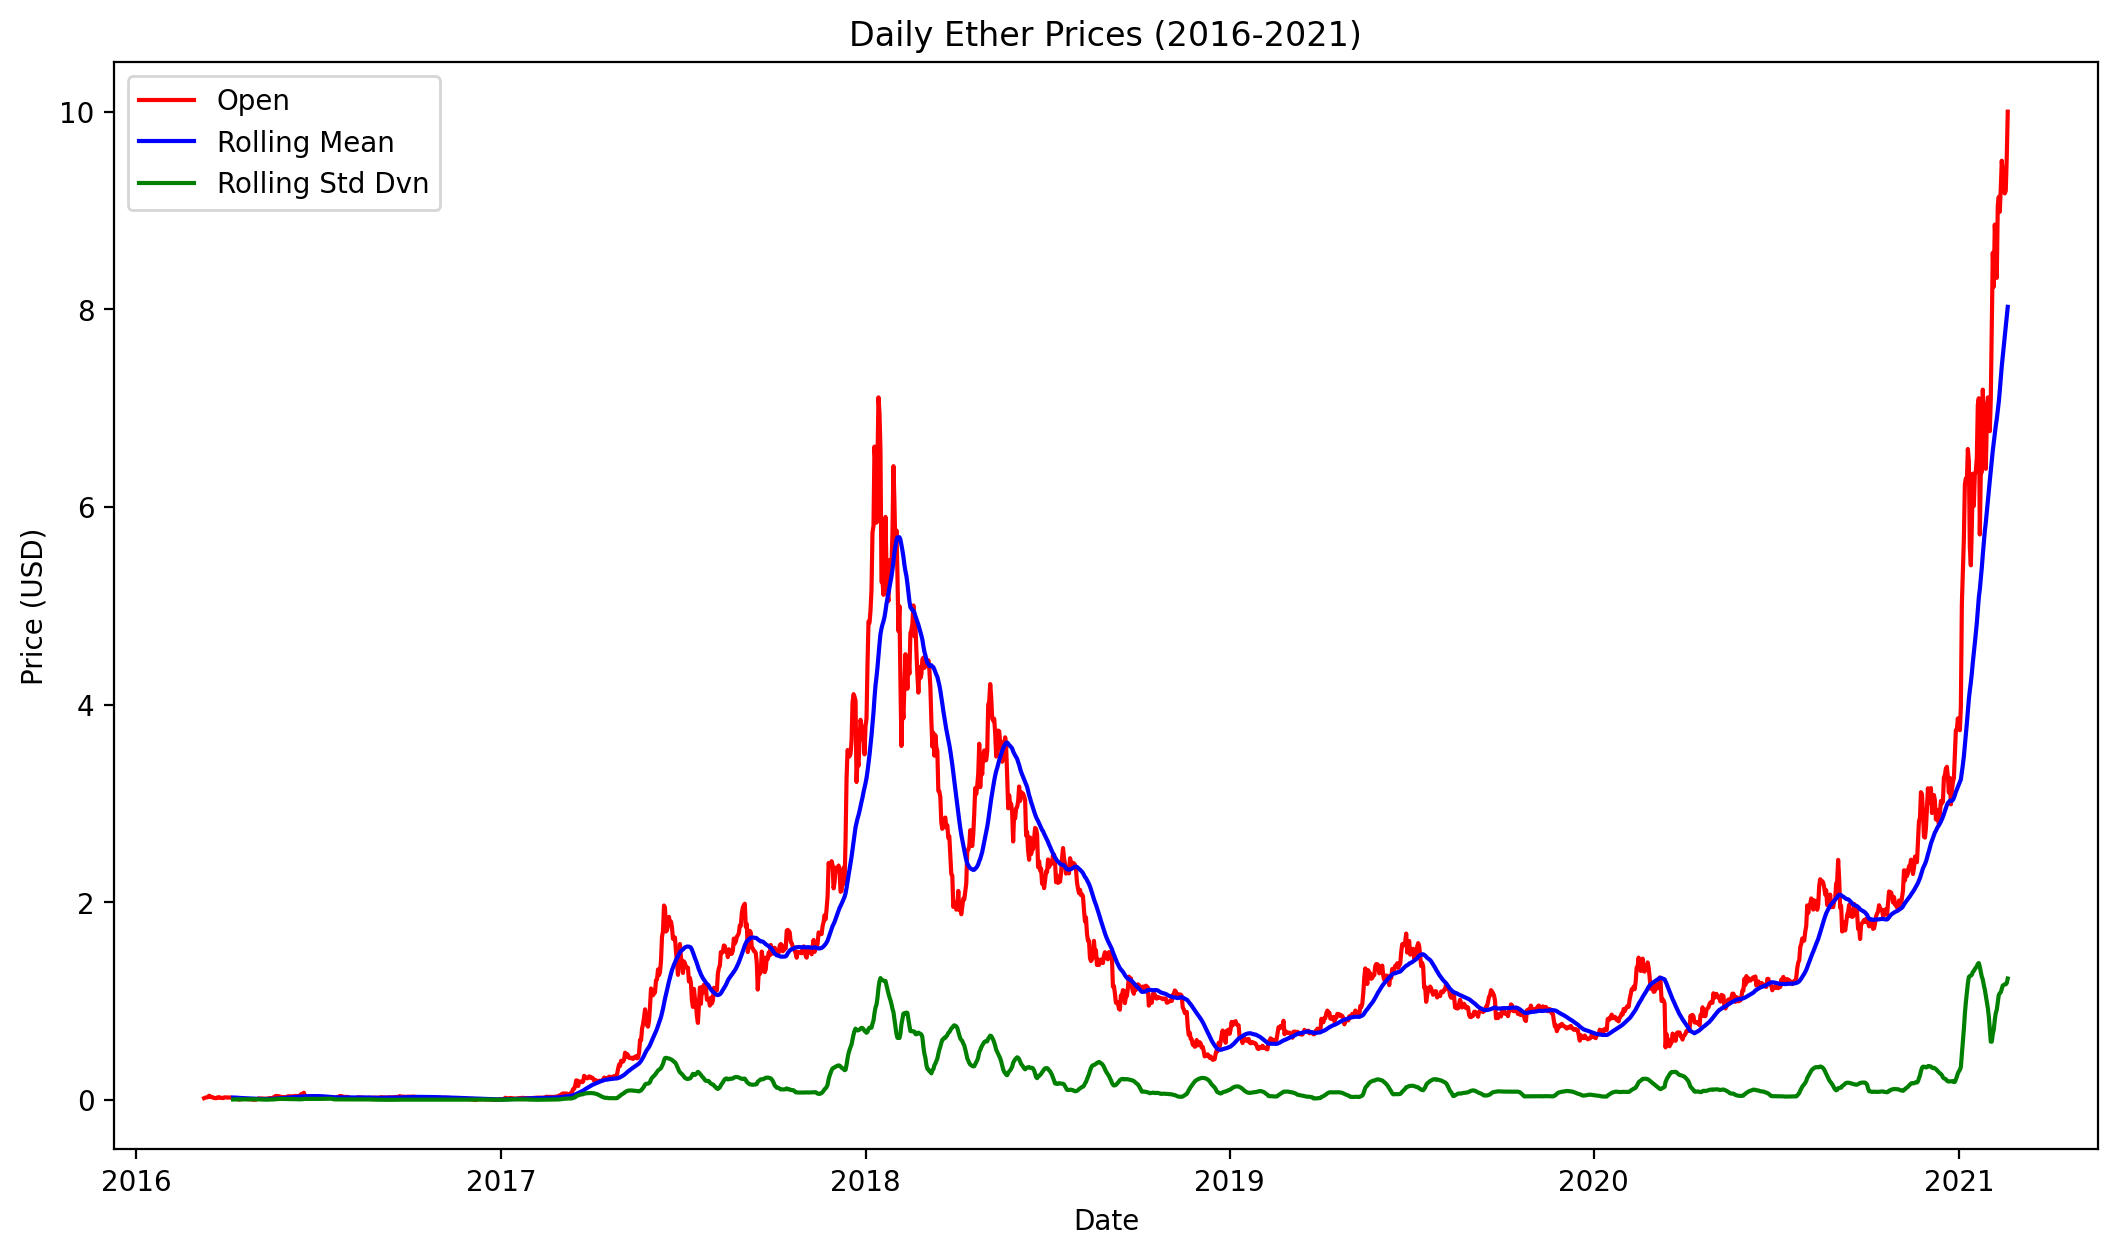

In [215]:
plt.figure(figsize=(12.80, 7.20), dpi=200)
plt.plot(normalized_ether_data["Open"], color="red", label="Open")
plt.plot(rolling_mean["Open"], color="blue", label="Rolling Mean")
plt.plot(rolling_standard_deviation["Open"], color="green", label="Rolling Std Dvn")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Daily Ether Prices (2016-2021)")
plt.show()